# HomeWork FRA502 Optimization
Implement Optimization on Rastrigin function to find the global minimum.

In [1]:
# Imports
import numpy as np 
import scipy 
import matplotlib.pyplot as plt 

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Rastrigin function
Initial rastrigin function to rady for optimization.
in this homework try to solve with this define function

$f(x) = 10d + \sum_{i=1}^{d} (x_i^2 - 10\cos(2\pi x_i))$

where:
- x is a numpy array of shape (d, 1)
- A = 10
- d is the dimension of x
- $x_i$ is the i-th element of x

80


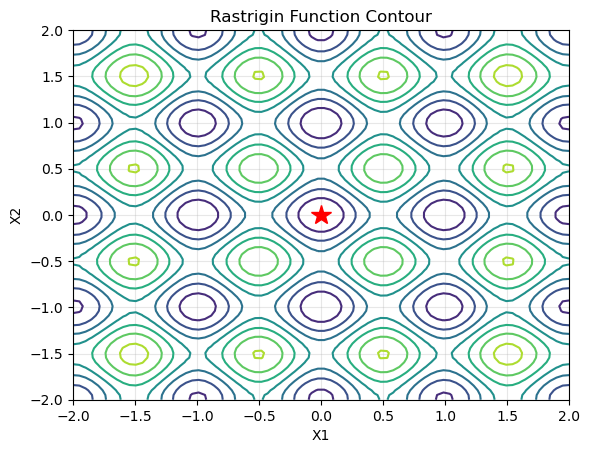

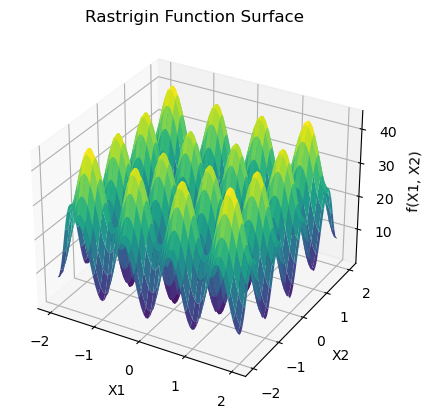

In [2]:
# Rastrigin function
# x is a numpy array of shape (d, 1)
def f(x):
    A = 10.
    d = x.shape[0]
    return A * d + np.sum(x.T @ x) - A * np.sum(np.cos(2. * np.pi * x))

# clear previous plot
plt.close()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Contour plot set to view -2 to 2 in both dimensions with 80 steps
N = 80 # 80 steps
x1 = np.linspace(-2., 2., N)
x2 = np.linspace(-2., 2., N)

# Create a meshgrid for contour plot
X, Y = np.meshgrid(x1, x2)
# Compute the function value on the grid
val = np.zeros((N, N))
# Loop over each point in the grid to compute f
for i in range(N):
    for j in range(N):
        xx = np.zeros((2, 1))
        xx[0] = X[i, j]
        xx[1] = Y[i, j]
        val[i, j] = f(xx)

# Show the contour plot length
print(len(val)) 
# Plot the computed values
ax.set_title('Rastrigin Function Contour')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.plot(0, 0, 'r*', markersize=15, label='Global Minimum (0,0)')
CS = ax.contour(x1.reshape((N,)), x2.reshape((N,)), val)
ax.grid(True, alpha=0.3)


# Try to 3d plot
fig3d = plt.figure()
ax3d = fig3d.add_subplot(111, projection='3d')
ax3d.plot_surface(X, Y, val, cmap='viridis', edgecolor='none')
ax3d.set_title('Rastrigin Function Surface')
ax3d.set_xlabel('X1')
ax3d.set_ylabel('X2')
ax3d.set_zlabel('f(X1, X2)')
plt.show()

### Newton's Method

Let's remember the Newton's method for **root finding**:

1) We first linearize around the current estimate $\boldsymbol{x}_k$:

$f(\boldsymbol{x}_k + \Delta\boldsymbol{x})\approx f(\boldsymbol{x}_k) + \frac{\partial f}{\partial\boldsymbol{x}}\Big|_{\boldsymbol{x}_k}\Delta\boldsymbol{x}$

2) We then set $f(\boldsymbol{x}_k + \Delta\boldsymbol{x}) = 0$ and solve for $\Delta\boldsymbol{x}$:

$f(\boldsymbol{x}_k) + \frac{\partial f}{\partial\boldsymbol{x}}\Big|_{\boldsymbol{x}_k}\Delta\boldsymbol{x} = 0$

$\Delta\boldsymbol{x} = -\Big(\frac{\partial f}{\partial\boldsymbol{x}}\Big|_{\boldsymbol{x}_k}\Big)^{-1}f(\boldsymbol{x}_k)$

3) We apply the correction $\boldsymbol{x}_{k+1} = \boldsymbol{x}_k + \Delta\boldsymbol{x}$

4) Repeat until convergence

Let's try the newton method on our `restrigin function`!


## Objective Function
Base from objective function of restrigin function:
$$f(x) = 10d + \sum_{i=1}^{d} (x_i^2 - 10\cos(2\pi x_i))$$
We need to find the gradient and hessian matrix of the function.
### Gradient
The gradient of the function is given by:
$$\nabla f(x) = 2x + 20\pi \sin(2\pi x)$$
### Hessian Matrix
The Hessian matrix of the function is given by:
$$H(x) = diag(2 + 40\pi^2 \cos(2\pi x_i))$$
where $diag$ denotes a diagonal matrix with the specified elements on the diagonal.

In [3]:
# ความชัน
def gradient_f(x):
    A = 10.
    return 2 * x + A * 2 * np.pi * np.sin(2 * np.pi * x)

# Hessian matrix หรือความโค้ง
def hessian_f(x):
    A = 10.
    diagonal_elements = 2 + 4 * (np.pi**2) * A * np.cos(2 * np.pi * x.T)
    return np.diag(diagonal_elements.flatten())

## Let's test the gradient and Hessian functions

Before implementing Newton's method, we need to ensure that our gradient and Hessian functions are correct.  
We’ll use a finite-difference (FD) method to verify them.

Finite differences approximate derivatives numerically:

### Gradient (first derivative)
For a scalar function $f:\mathbb{R}^d \to \mathbb{R}$ and unit basis $e_i$,
$$
\nabla f(x) \;\approx\;
\begin{bmatrix}
\frac{f(x+\varepsilon e_1)-f(x-\varepsilon e_1)}{2\varepsilon}\\[6pt]
\vdots\\[2pt]
\frac{f(x+\varepsilon e_d)-f(x-\varepsilon e_d)}{2\varepsilon}
\end{bmatrix}.
$$

### Hessian (second derivatives)
Differentiate the gradient components with the same central difference:
$$
\left[\nabla^2 f(x)\right]_{:,i}
\;\approx\;
\frac{\nabla f(x+\varepsilon e_i)-\nabla f(x-\varepsilon e_i)}{2\varepsilon},
\quad i=1,\dots,d.
$$

### Practical notes
- **Central difference** has truncation error $O(\varepsilon^2)$; too small $\varepsilon$ causes round-off.  
  A good default is $\varepsilon \in [10^{-6},10^{-4}]$.
- Compare the analytic derivatives against FD using tolerances, e.g.
  $\text{rtol}=\text{atol}=10^{-3}$ for most smooth functions.
- Ensure consistent **shapes**: treat $x$ as $(d,)$ or $(d,1)$ uniformly; reshape as needed.



In [4]:
def finite_diff(f, z, M, eps=1e-4):
    z = np.asarray(z, dtype=float)           # (N, 1) or (N,)
    z = z.reshape(-1, 1)
    N = z.shape[0]
    jac = np.zeros((M, N))
    for i in range(N):
        e = np.zeros_like(z)
        e[i, 0] = eps
        fp = f(z + e)
        fm = f(z - e)
        col = (fp - fm) / (2.0 * eps)
        jac[:, i:i+1] = np.asarray(col).reshape(M, 1)
    return jac

print("Testing gradient and Hessian...")
for i in range(100):
    x = np.random.randn(2, 1)
    
    # Test gradient (add .T to gradient_f)
    assert(np.isclose(finite_diff(f, x, 1), gradient_f(x).T, rtol=1e-3, atol=1e-3).all())
    
    # Test Hessian
    assert(np.isclose(finite_diff(gradient_f, x, x.shape[0]), hessian_f(x), rtol=1e-3, atol=1e-3).all())

print("✅ All 100 tests passed! Your gradient and Hessian are correct!")

Testing gradient and Hessian...
✅ All 100 tests passed! Your gradient and Hessian are correct!


## Let's start optimization with Newton's Method
Now that we have verified our gradient and Hessian functions, we can implement Newton's method to find the minimum of the Rastrigin function.

Initial value: 14.580169943749475


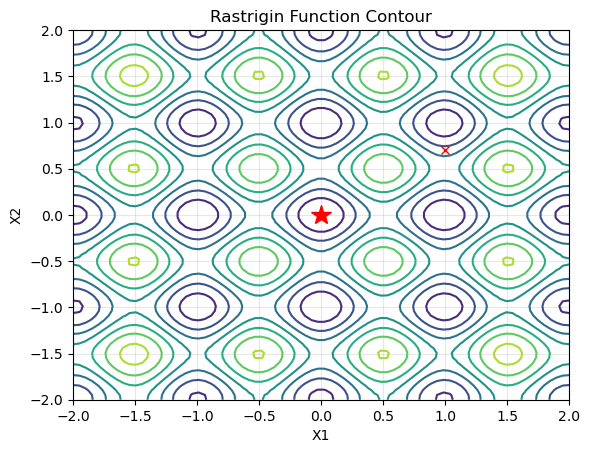

In [5]:
# Initial point
x0 = np.array([[1., 0.7]]).T


ax.plot(x0[0, 0], x0[1, 0], 'rx')

print("Initial value:", f(x0))

fig # show figure again with updated point(s)

In [6]:
def newton_step(x):
    grad = gradient_f(x) 
    hessian = hessian_f(x)
    # dx = -np.linalg.inv(hessian) @ grad
    dx = -np.linalg.solve(hessian, grad)
    return x + dx

## Test Newton's Method
We can now test our Newton's method implementation on the Rastrigin function. We'll start from a random initial point and iterate until convergence.

In [7]:
np.random.seed(10)


x = np.random.randn(2, 1)
print(f"Starting point x: {x.T}")
xn = newton_step(x)
print(f"After Newton step: {xn.T}")
print(f"Expected: [[1.63122303, -0.0027116]]")
assert(np.isclose(xn, np.array([[1.63122303, -0.0027116]]).T, rtol=1e-3, atol=1e-3).all())



x = np.random.randn(2, 1)
print(f"Starting point x: {x.T}")
xn = newton_step(x)
print(f"After Newton step: {xn.T}")
print(f"Expected: [[-1.50668149, 0.]]")
assert(np.isclose(xn, np.array([[-1.50668149, 0.]]).T, rtol=1e-3, atol=1e-3).all())



x = np.random.randn(2, 1)
print(f"Starting point x: {x.T}")
xn = newton_step(x)
print(f"After Newton step: {xn.T}")
print(f"Expected: [[0.47265641, 0.11992915]]")
assert(np.isclose(xn, np.array([[0.47265641, 0.11992915]]).T, rtol=1e-3, atol=1e-3).all())


np.random.seed(None)

Starting point x: [[1.3315865  0.71527897]]
After Newton step: [[ 1.63122303 -0.0027116 ]]
Expected: [[1.63122303, -0.0027116]]
Starting point x: [[-1.54540029 -0.00838385]]
After Newton step: [[-1.50668149e+00  7.72420239e-06]]
Expected: [[-1.50668149, 0.]]
Starting point x: [[ 0.62133597 -0.72008556]]
After Newton step: [[0.47265641 0.11992915]]
Expected: [[0.47265641, 0.11992915]]


## Let's start optimization with Newton's Method
Now that we have verified our newton's method is working, we can implement Newton's method to find the minimum of the Rastrigin function.

In [8]:
# Let's start solving
x = np.copy(x0)

## Now let's see the result of optimization!

step  1 | x = [0.99495948 0.21367445] -> f = 8.777979
step  2 | x = [ 0.99495864 -0.46116288] -> f = 20.911374
step  3 | x = [ 0.99495864 -0.50341789] -> f = 21.246083
step  4 | x = [ 0.99495864 -0.50254599] -> f = 21.246232
step  5 | x = [ 0.99495864 -0.50254604] -> f = 21.246232
step  6 | x = [ 0.99495864 -0.50254604] -> f = 21.246232
step  7 | x = [ 0.99495864 -0.50254604] -> f = 21.246232
step  8 | x = [ 0.99495864 -0.50254604] -> f = 21.246232
step  9 | x = [ 0.99495864 -0.50254604] -> f = 21.246232
step 10 | x = [ 0.99495864 -0.50254604] -> f = 21.246232
step 11 | x = [ 0.99495864 -0.50254604] -> f = 21.246232
step 12 | x = [ 0.99495864 -0.50254604] -> f = 21.246232
step 13 | x = [ 0.99495864 -0.50254604] -> f = 21.246232
step 14 | x = [ 0.99495864 -0.50254604] -> f = 21.246232
step 15 | x = [ 0.99495864 -0.50254604] -> f = 21.246232
step 16 | x = [ 0.99495864 -0.50254604] -> f = 21.246232
step 17 | x = [ 0.99495864 -0.50254604] -> f = 21.246232
step 18 | x = [ 0.99495864 -0.5025

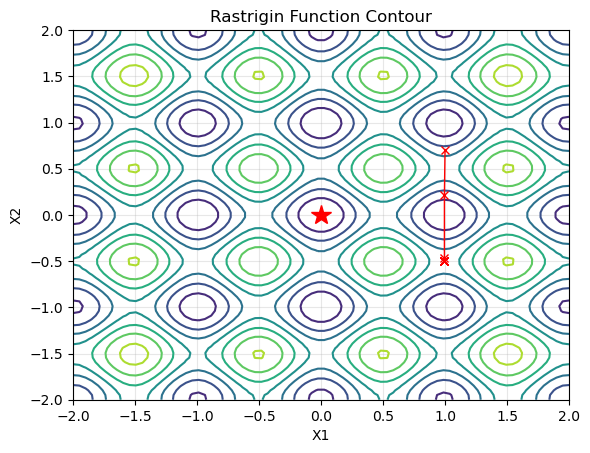

In [9]:

iterations = 20
px, py = [x[0,0]], [x[1,0]]  # to draw a path

for it in range(1, iterations + 1):
    x = newton_step(x)             # one Newton step (no damping/Armijo)
    fx = float(f(x))        # your scalar objective
    print(f"step {it:2d} | x = {x.ravel()} -> f = {fx:.6f}")

    # plot the new point and a short segment from the previous point
    ax.plot(x[0,0], x[1,0], 'rx', ms=6, label=None)
    ax.plot([px[-1], x[0,0]], [py[-1], x[1,0]], 'r-', lw=1)
    px.append(x[0,0]); py.append(x[1,0])

fig

As you can see in this case I have set init point at `x0 = np.array([[1., 0.7]]).T
` or (1.0, 0.7) and I have implement newton's method to optimize the function. After 20 iterations, this can see around step 2-3 that result is around 20-21 whcih mean at this point we found a local maximum or mean the hessian is not Positive definite and the optimization is not converging to the global minimum at (0,0) with f(0,0)=0.

## Try to add damping
This will help to ensure that the Hessian is positive definite and improve convergence.

$\boldsymbol{H} = \nabla^2_{\boldsymbol{x}}f(\boldsymbol{x}_k)$

$\text{while } \boldsymbol{H}\preceq 0:$

$\quad\boldsymbol{H} = \boldsymbol{H} + \beta\boldsymbol{I}$

$\Delta\boldsymbol{x} = -\boldsymbol{H}^{-1}\nabla_{\boldsymbol{x}}f(\boldsymbol{x}_k)$

$\boldsymbol{x}_{k+1} = \boldsymbol{x}_k + \Delta\boldsymbol{x}$

In [10]:
def is_pos_def(x):
    """ Check if matrix is positive definite """
    return np.all(np.linalg.eigvals(x) > 0)

def damped_newton_step(x, beta = 100.):
    """ Damped Newton step with damping factor `beta` """
    grad = gradient_f(x) 
    hessian = hessian_f(x)
    d = hessian.shape[0]
    I = np.eye(d)
    while not is_pos_def(hessian):
        hessian += beta * I

    dx = -np.linalg.solve(hessian, grad)
    return x + dx
    

## Re-plot Rastrigin Function

80


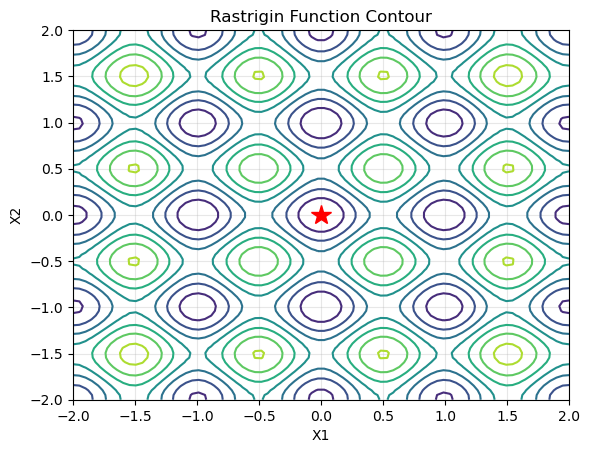

In [11]:
def f(x):
    A = 10.
    d = x.shape[0]
    return A * d + np.sum(x.T @ x) - A * np.sum(np.cos(2. * np.pi * x))

# clear previous plot
plt.close()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Contour plot set to view -2 to 2 in both dimensions with 80 steps
N = 80 # 80 steps
x1 = np.linspace(-2., 2., N)
x2 = np.linspace(-2., 2., N)

# Create a meshgrid for contour plot
X, Y = np.meshgrid(x1, x2)
# Compute the function value on the grid
val = np.zeros((N, N))
# Loop over each point in the grid to compute f
for i in range(N):
    for j in range(N):
        xx = np.zeros((2, 1))
        xx[0] = X[i, j]
        xx[1] = Y[i, j]
        val[i, j] = f(xx)

# Show the contour plot length
print(len(val)) 
# Plot the computed values
ax.set_title('Rastrigin Function Contour')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.plot(0, 0, 'r*', markersize=15, label='Global Minimum (0,0)')
CS = ax.contour(x1.reshape((N,)), x2.reshape((N,)), val)
ax.grid(True, alpha=0.3)


Initial value: 14.580169943749475


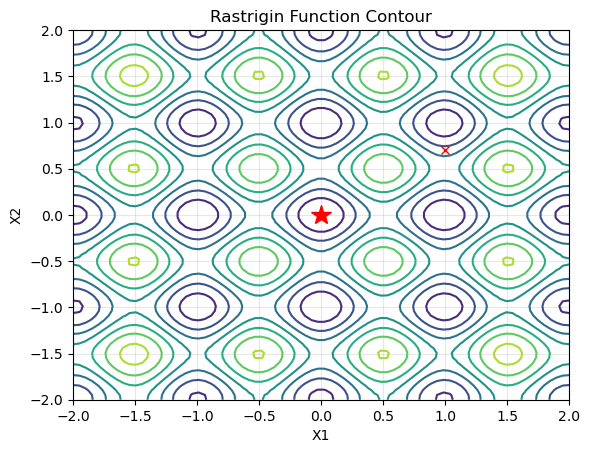

In [12]:
# Initial point
x0 = np.array([[1., 0.7]]).T


ax.plot(x0[0, 0], x0[1, 0], 'rx')

print("Initial value:", f(x0))

fig # show figure again with updated point(s)

step  1 | x = [0.9966487  1.42941263] -> f = 22.071241
step  2 | x = [0.99580728 0.77272786] -> f = 10.169025
step  3 | x = [0.9949587  1.81503654] -> f = 10.315731
step  4 | x = [0.99495864 2.1551141 ] -> f = 10.024573
step  5 | x = [0.99495864 1.9033898 ] -> f = 6.404335
step  6 | x = [0.99495864 2.00157601] -> f = 5.001756
step  7 | x = [0.99495864 1.98991841] -> f = 4.974790
step  8 | x = [0.99495864 1.98991223] -> f = 4.974790
step  9 | x = [0.99495864 1.98991223] -> f = 4.974790
step 10 | x = [0.99495864 1.98991223] -> f = 4.974790
step 11 | x = [0.99495864 1.98991223] -> f = 4.974790
step 12 | x = [0.99495864 1.98991223] -> f = 4.974790
step 13 | x = [0.99495864 1.98991223] -> f = 4.974790
step 14 | x = [0.99495864 1.98991223] -> f = 4.974790
step 15 | x = [0.99495864 1.98991223] -> f = 4.974790
step 16 | x = [0.99495864 1.98991223] -> f = 4.974790
step 17 | x = [0.99495864 1.98991223] -> f = 4.974790
step 18 | x = [0.99495864 1.98991223] -> f = 4.974790
step 19 | x = [0.9949586

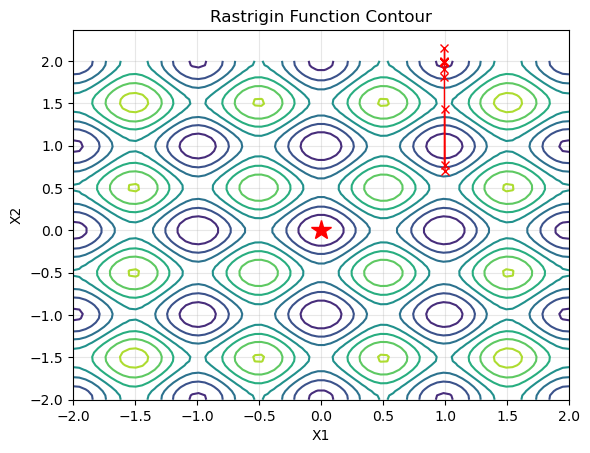

In [13]:
# Let's start solving
x = np.copy(x0)


iterations = 20
px, py = [x[0,0]], [x[1,0]]  # to draw a path

for it in range(1, iterations + 1):
    x = damped_newton_step(x)             # one Newton step (no damping/Armijo)
    fx = float(f(x))        # your scalar objective
    print(f"step {it:2d} | x = {x.ravel()} -> f = {fx:.6f}")

    # plot the new point and a short segment from the previous point
    ax.plot(x[0,0], x[1,0], 'rx', ms=6, label=None)
    ax.plot([px[-1], x[0,0]], [py[-1], x[1,0]], 'r-', lw=1)
    px.append(x[0,0]); py.append(x[1,0])

fig

Based on the results after adding damping to the Hessian matrix with beta = 100.0 for the around step 1-2, we can see that f is decreasing from around 22 to 10. After that, around step 2-3, it overshoots from 10.169 to 10.316. This makes the results move to another basin and then try to converge with f around 4.974790, which is still a local minimum, not the global minimum.

## Try to use line search let's use Armijo backtracking line search
To improve convergence, we can implement Armijo backtracking line search to find an appropriate step size $\alpha$ at each iteration.

$\alpha = 1$

$\text{while } f(\boldsymbol{x}_k + \alpha\Delta\boldsymbol{x}) > f(\boldsymbol{x}_k) + b\alpha\nabla_{\boldsymbol{x}}f(\boldsymbol{x}_k)^T\Delta\boldsymbol{x}:$

$\quad\alpha = c\alpha$

$\boldsymbol{x}_{k+1} = \boldsymbol{x}_k + \alpha\Delta\boldsymbol{x}$

where $0<c<1$ and $b$ is something small.

In [14]:
# implemnt damped _ armijo newton step
def armijo_newton_step(x, beta = 1., b = 0.1, c = 0.5):
    grad = gradient_f(x) 
    hessian = hessian_f(x)

    d = hessian.shape[0]
    I = np.eye(d)

    while not is_pos_def(hessian):
       hessian += beta * I

    dx = -np.linalg.solve(hessian, grad)
    a = 1.0
    fx = f(x)
    gT_dx = (grad.T @ dx).item()

    while f(x + a*dx) > fx + b * a * gT_dx:
        a = c * a
    return x + a * dx

## Re-plot Rastrigin Function

80


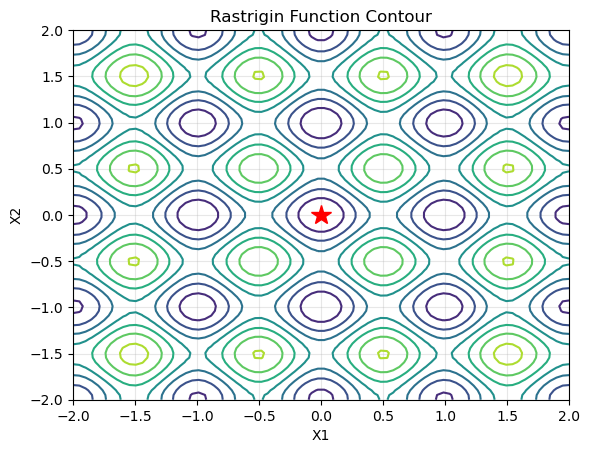

In [15]:
def f(x):
    A = 10.
    d = x.shape[0]
    return A * d + np.sum(x.T @ x) - A * np.sum(np.cos(2. * np.pi * x))

# clear previous plot
plt.close()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Contour plot set to view -2 to 2 in both dimensions with 80 steps
N = 80 # 80 steps
x1 = np.linspace(-2., 2., N)
x2 = np.linspace(-2., 2., N)

# Create a meshgrid for contour plot
X, Y = np.meshgrid(x1, x2)
# Compute the function value on the grid
val = np.zeros((N, N))
# Loop over each point in the grid to compute f
for i in range(N):
    for j in range(N):
        xx = np.zeros((2, 1))
        xx[0] = X[i, j]
        xx[1] = Y[i, j]
        val[i, j] = f(xx)

# Show the contour plot length
print(len(val)) 
# Plot the computed values
ax.set_title('Rastrigin Function Contour')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.plot(0, 0, 'r*', markersize=15, label='Global Minimum (0,0)')
CS = ax.contour(x1.reshape((N,)), x2.reshape((N,)), val)
ax.grid(True, alpha=0.3)


Initial value: 14.580169943749475


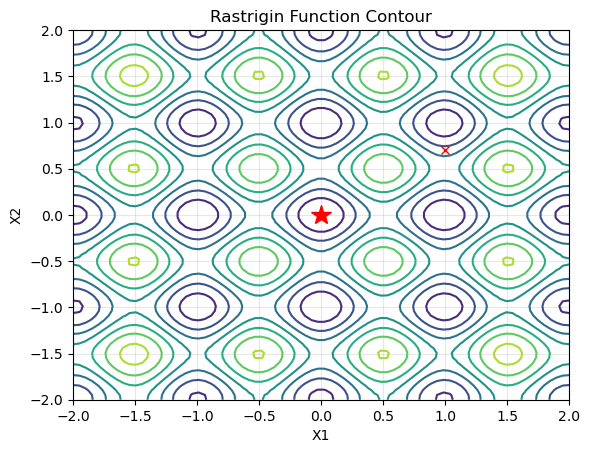

In [16]:
# Initial point
x0 = np.array([[1., 0.7]]).T


ax.plot(x0[0, 0], x0[1, 0], 'rx')

print("Initial value:", f(x0))

fig # show figure again with updated point(s)

step  1 | x = [0.99999988 1.05757579] -> f = 2.765710
step  2 | x = [0.99495948 0.99197633] -> f = 1.991681
step  3 | x = [0.99495864 0.99495987] -> f = 1.989918
step  4 | x = [0.99495864 0.99495864] -> f = 1.989918
step  5 | x = [0.99495864 0.99495864] -> f = 1.989918
step  6 | x = [0.99495864 0.99495864] -> f = 1.989918
step  7 | x = [0.99495864 0.99495864] -> f = 1.989918
step  8 | x = [0.99495864 0.99495864] -> f = 1.989918
step  9 | x = [0.99495864 0.99495864] -> f = 1.989918
step 10 | x = [0.99495864 0.99495864] -> f = 1.989918
step 11 | x = [0.99495864 0.99495864] -> f = 1.989918
step 12 | x = [0.99495864 0.99495864] -> f = 1.989918
step 13 | x = [0.99495864 0.99495864] -> f = 1.989918
step 14 | x = [0.99495864 0.99495864] -> f = 1.989918
step 15 | x = [0.99495864 0.99495864] -> f = 1.989918
step 16 | x = [0.99495864 0.99495864] -> f = 1.989918
step 17 | x = [0.99495864 0.99495864] -> f = 1.989918
step 18 | x = [0.99495864 0.99495864] -> f = 1.989918
step 19 | x = [0.99495864 0.

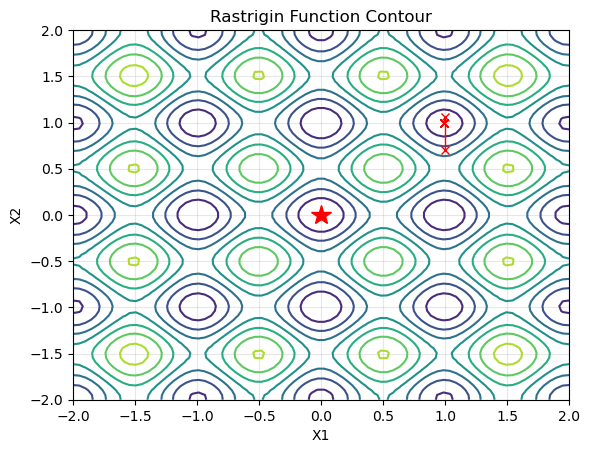

In [17]:
# Let's start solving
x = np.copy(x0)


iterations = 20
px, py = [x[0,0]], [x[1,0]]  # to draw a path

for it in range(1, iterations + 1):
    x = armijo_newton_step(x)             # on e Newton step (no damping/Armijo)
    fx = float(f(x))        # your scalar objective
    print(f"step {it:2d} | x = {x.ravel()} -> f = {fx:.6f}")

    # plot the new point and a short segment from the previous point
    ax.plot(x[0,0], x[1,0], 'rx', ms=6, label=None)
    ax.plot([px[-1], x[0,0]], [py[-1], x[1,0]], 'r-', lw=1)
    px.append(x[0,0]); py.append(x[1,0])

fig

Based on the results after adding Armijo backtracking line search, we can see that the optimization process is more robust and converges more reliably to the minimum. However the results is still stuck at local minimum not the global minimum due to this function having many local minima.

80


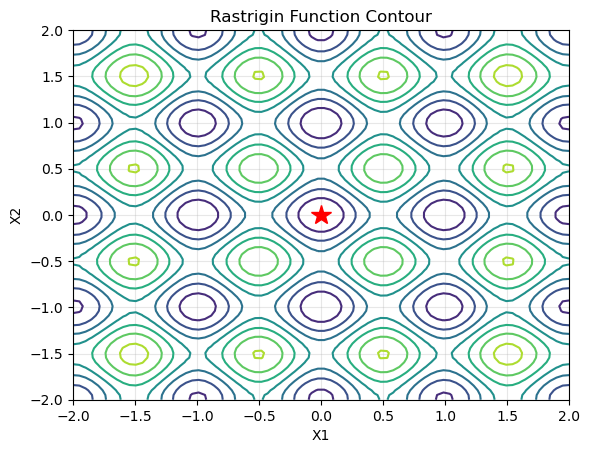

In [18]:
def f(x):
    A = 10.
    d = x.shape[0]
    return A * d + np.sum(x.T @ x) - A * np.sum(np.cos(2. * np.pi * x))

# clear previous plot
plt.close()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Contour plot set to view -2 to 2 in both dimensions with 80 steps
N = 80 # 80 steps
x1 = np.linspace(-2., 2., N)
x2 = np.linspace(-2., 2., N)

# Create a meshgrid for contour plot
X, Y = np.meshgrid(x1, x2)
# Compute the function value on the grid
val = np.zeros((N, N))
# Loop over each point in the grid to compute f
for i in range(N):
    for j in range(N):
        xx = np.zeros((2, 1))
        xx[0] = X[i, j]
        xx[1] = Y[i, j]
        val[i, j] = f(xx)

# Show the contour plot length
print(len(val)) 
# Plot the computed values
ax.set_title('Rastrigin Function Contour')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.plot(0, 0, 'r*', markersize=15, label='Global Minimum (0,0)')
CS = ax.contour(x1.reshape((N,)), x2.reshape((N,)), val)
ax.grid(True, alpha=0.3)


Initial value: 14.580169943749475


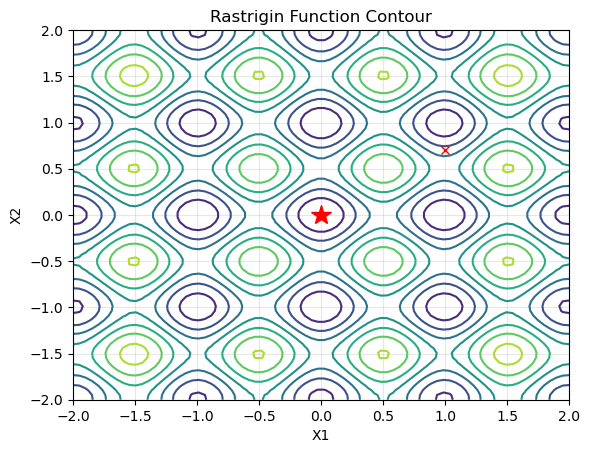

In [19]:
# Initial point
x0 = np.array([[1., 0.7]]).T


ax.plot(x0[0, 0], x0[1, 0], 'rx')

print("Initial value:", f(x0))

fig # show figure again with updated point(s)

---
## Finding Global Minimum: Multi-Start Optimization

**The Problem:** Newton's method is a **local optimizer** - it converges to the nearest local minimum from the starting point. The Rastrigin function has many local minima.

**The Solution:** Try multiple random starting points and pick the best result!

In [20]:
def newton_optimize(x0, max_iters=100, tol=1e-8, plot=False, **stepkw):
    """
    Run damped+Armijo Newton from x0.
    Returns (x_best, f_best, history), where history is a list of (x,f)
    """
    x0_vec = np.asarray(x0, float).reshape(-1, 1)
    
    x = x0_vec.copy()
    hist = [(x.copy(), float(f(x)))]
    
    for _ in range(max_iters):
        x_new = armijo_newton_step(x, **stepkw)
        f_new = float(f(x_new))
        hist.append((x_new.copy(), f_new))
        
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
    
    # pick best in history
    xb, fb = min(hist, key=lambda t: t[1])
    return xb.ravel(), fb, hist


def multi_start_optimize(n_starts=50, bounds=(-2, 2), **opt_kwargs):
    """
    Multi-start optimization: run optimizer from multiple random starting points
    
    Args:
        n_starts: number of random starting points to try
        bounds: tuple (min, max) for random initialization
        **opt_kwargs: keyword arguments passed to newton_optimize
    
    Returns:
        best_x, best_f, all_results
    """
    np.random.seed(42)  # for reproducibility
    results = []
    
    for i in range(n_starts):
        # Random starting point in the bounds
        x0 = np.random.uniform(bounds[0], bounds[1], size=(2, 1))
        
        # Run optimization
        x_opt, f_opt, history = newton_optimize(x0, **opt_kwargs)
        results.append((x_opt, f_opt, history))
        
        if (i + 1) % 10 == 0:
            print(f"Completed {i+1}/{n_starts} starts...")
    
    # Find the best result
    best_x, best_f, best_hist = min(results, key=lambda t: t[1])
    
    print(f"\n{'='*60}")
    print(f"Multi-start optimization results:")
    print(f"{'='*60}")
    print(f"Number of random starts: {n_starts}")
    print(f"Best result found: x = {best_x}, f(x) = {best_f:.10f}")
    print(f"Global minimum: x = [0, 0], f(x) = 0.0")
    print(f"Distance to global minimum: {np.linalg.norm(best_x):.10f}")
    print(f"{'='*60}\n")
    
    return best_x, best_f, results


# Run multi-start optimization
best_x, best_f, all_results = multi_start_optimize(
    n_starts=50, 
    bounds=(-2, 2),
    max_iters=100,
    beta=100.0,
    b=0.1,
    c=0.5,
    tol=1e-8
)

Completed 10/50 starts...
Completed 20/50 starts...
Completed 30/50 starts...
Completed 40/50 starts...
Completed 50/50 starts...

Multi-start optimization results:
Number of random starts: 50
Best result found: x = [0.00000000e+00 7.39089085e-12], f(x) = 0.0000000000
Global minimum: x = [0, 0], f(x) = 0.0
Distance to global minimum: 0.0000000000



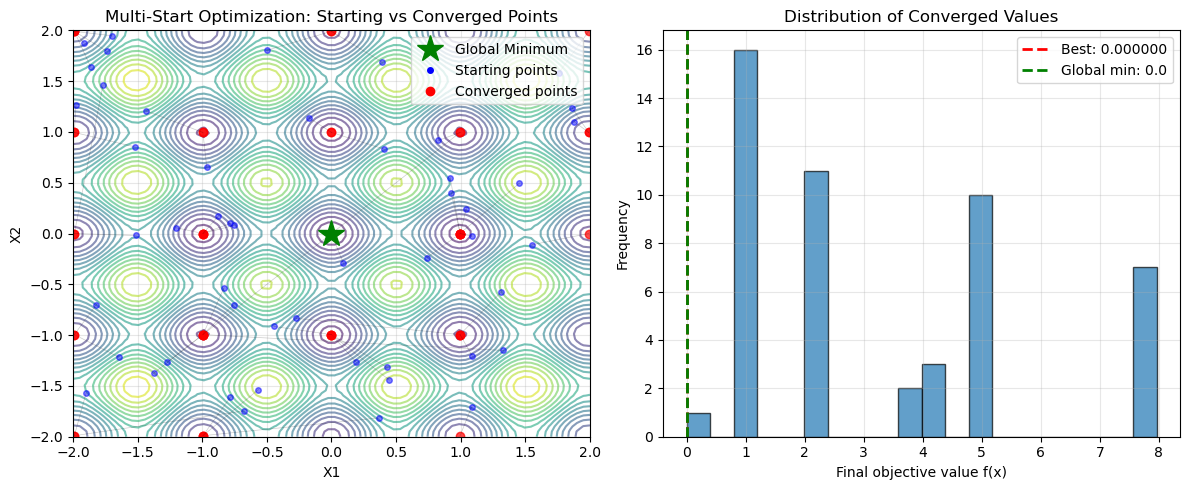

Best solution found: x = [0.00000000e+00 7.39089085e-12]
Function value: f(x) = 0.0000000000
Error from global minimum: 0.0000000000e+00


In [21]:
# Visualize all the starting points and where they converged
plt.close()
fig2 = plt.figure(figsize=(12, 5))

# Left plot: show all starting points and convergence points
ax1 = fig2.add_subplot(1, 2, 1)
ax1.contour(x1, x2, val, levels=20, alpha=0.6)
ax1.set_title('Multi-Start Optimization: Starting vs Converged Points')
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.plot(0, 0, 'g*', markersize=20, label='Global Minimum', zorder=10)

# Plot starting points and converged points
for x_opt, f_opt, history in all_results:
    x_start = history[0][0].ravel()  # starting point, flatten to 1D
    x_opt_flat = x_opt.ravel()  # converged point, flatten to 1D
    ax1.plot(x_start[0], x_start[1], 'b.', markersize=8, alpha=0.5)
    ax1.plot(x_opt_flat[0], x_opt_flat[1], 'ro', markersize=6, alpha=0.7)
    # Draw line from start to end
    ax1.plot([x_start[0], x_opt_flat[0]], [x_start[1], x_opt_flat[1]], 
             'k-', alpha=0.2, linewidth=0.5)

ax1.plot([], [], 'b.', markersize=8, label='Starting points')
ax1.plot([], [], 'ro', markersize=6, label='Converged points')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right plot: histogram of final function values
ax2 = fig2.add_subplot(1, 2, 2)
final_values = [f_opt for _, f_opt, _ in all_results]
ax2.hist(final_values, bins=20, edgecolor='black', alpha=0.7)
ax2.axvline(best_f, color='r', linestyle='--', linewidth=2, label=f'Best: {best_f:.6f}')
ax2.axvline(0.0, color='g', linestyle='--', linewidth=2, label='Global min: 0.0')
ax2.set_xlabel('Final objective value f(x)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Converged Values')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Best solution found: x = {best_x}")
print(f"Function value: f(x) = {best_f:.10f}")
print(f"Error from global minimum: {best_f:.10e}")

---
## Strategy 2: Global Optimization with SciPy

Python's SciPy library provides several global optimization algorithms that are specifically designed to find global minima. Let's try a few popular ones:

In [22]:
from scipy.optimize import differential_evolution, basinhopping, shgo, dual_annealing

# Define objective function for scipy (expects 1D array)
def f_scipy(x):
    x_reshaped = x.reshape(-1, 1)
    return f(x_reshaped)

# Define bounds for optimization
bounds = [(-2, 2), (-2, 2)]

print("="*70)
print("GLOBAL OPTIMIZATION METHODS COMPARISON")
print("="*70)

# 1. Differential Evolution (Evolutionary algorithm)
print("\n1. Differential Evolution:")
result_de = differential_evolution(f_scipy, bounds, seed=42, maxiter=1000)
print(f"   Solution: x = {result_de.x}")
print(f"   Objective: f(x) = {result_de.fun:.10f}")
print(f"   Distance from origin: {np.linalg.norm(result_de.x):.10f}")

# 2. Basin-hopping (Random jumps + local optimization)
print("\n2. Basin-Hopping:")
x0_bh = np.array([1.0, 0.7])
result_bh = basinhopping(f_scipy, x0_bh, niter=200, seed=42)
print(f"   Solution: x = {result_bh.x}")
print(f"   Objective: f(x) = {result_bh.fun:.10f}")
print(f"   Distance from origin: {np.linalg.norm(result_bh.x):.10f}")

# 3. Dual Annealing (Simulated annealing)
print("\n3. Dual Annealing:")
result_da = dual_annealing(f_scipy, bounds, seed=42, maxiter=1000)
print(f"   Solution: x = {result_da.x}")
print(f"   Objective: f(x) = {result_da.fun:.10f}")
print(f"   Distance from origin: {np.linalg.norm(result_da.x):.10f}")

# 4. SHGO (Simplicial Homology Global Optimization)
print("\n4. SHGO (Simplicial Homology):")
result_shgo = shgo(f_scipy, bounds)
print(f"   Solution: x = {result_shgo.x}")
print(f"   Objective: f(x) = {result_shgo.fun:.10f}")
print(f"   Distance from origin: {np.linalg.norm(result_shgo.x):.10f}")

print("\n" + "="*70)
print("GLOBAL MINIMUM (True): x = [0, 0], f(x) = 0.0")
print("="*70)

GLOBAL OPTIMIZATION METHODS COMPARISON

1. Differential Evolution:
   Solution: x = [1.11746568e-09 1.47347112e-09]
   Objective: f(x) = 0.0000000000
   Distance from origin: 0.0000000018

2. Basin-Hopping:
   Solution: x = [-1.73627995e-10 -3.46752480e-09]
   Objective: f(x) = 0.0000000000
   Distance from origin: 0.0000000035

3. Dual Annealing:
   Solution: x = [-4.10996438e-09 -5.57078327e-09]
   Objective: f(x) = 0.0000000000
   Distance from origin: 0.0000000069

4. SHGO (Simplicial Homology):
   Solution: x = [-2.25357084e-11 -2.25357084e-11]
   Objective: f(x) = 0.0000000000
   Distance from origin: 0.0000000000

GLOBAL MINIMUM (True): x = [0, 0], f(x) = 0.0


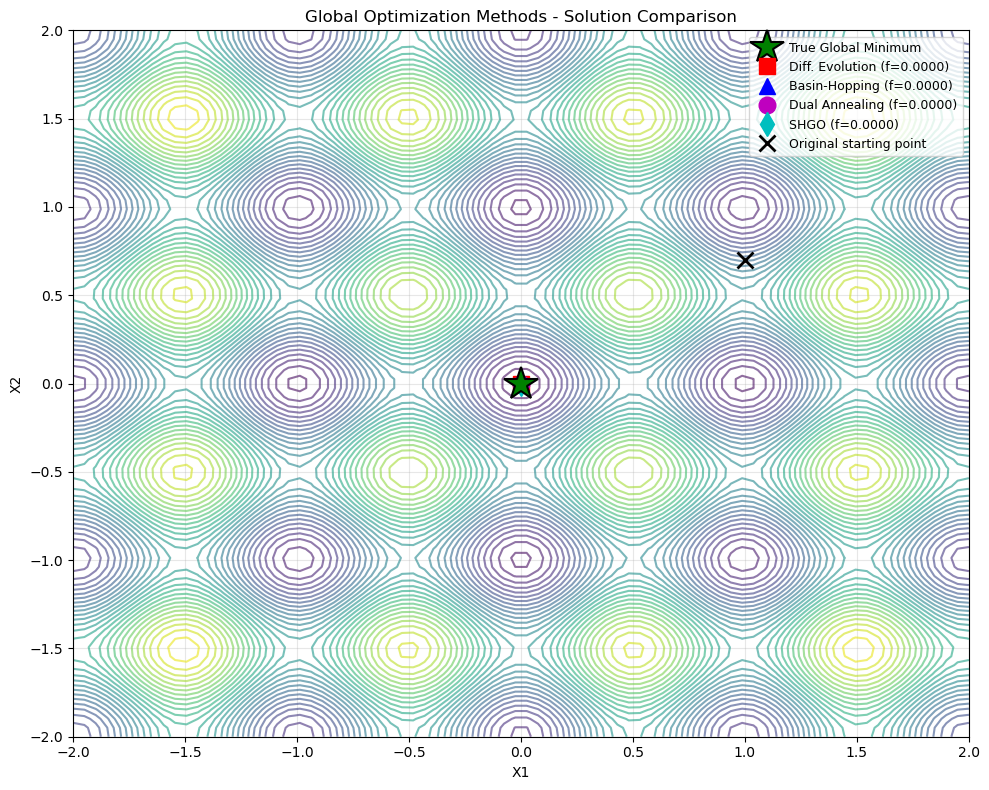

In [23]:
# Visualize the results from different methods
plt.close()
fig3 = plt.figure(figsize=(10, 8))
ax3 = fig3.add_subplot(1, 1, 1)

# Plot contour
ax3.contour(x1, x2, val, levels=30, alpha=0.6)
ax3.set_title('Global Optimization Methods - Solution Comparison')
ax3.set_xlabel('X1')
ax3.set_ylabel('X2')

# Plot global minimum
ax3.plot(0, 0, 'g*', markersize=25, label='True Global Minimum', zorder=10, 
         markeredgecolor='black', markeredgewidth=1.5)

# Plot results from different methods
ax3.plot(result_de.x[0], result_de.x[1], 'rs', markersize=12, 
         label=f'Diff. Evolution (f={result_de.fun:.4f})', zorder=9)
ax3.plot(result_bh.x[0], result_bh.x[1], 'b^', markersize=12, 
         label=f'Basin-Hopping (f={result_bh.fun:.4f})', zorder=9)
ax3.plot(result_da.x[0], result_da.x[1], 'mo', markersize=12, 
         label=f'Dual Annealing (f={result_da.fun:.4f})', zorder=9)
ax3.plot(result_shgo.x[0], result_shgo.x[1], 'cd', markersize=12, 
         label=f'SHGO (f={result_shgo.fun:.4f})', zorder=9)

# Plot original Newton result from (1.0, 0.7) for comparison
ax3.plot(1.0, 0.7, 'kx', markersize=12, 
         label='Original starting point', zorder=8, markeredgewidth=2)

ax3.legend(loc='upper right', fontsize=9)
ax3.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## Summary: How to Find Global Minimum Instead of Local Minimum

### The Problem
**Newton's method** (and other gradient-based local optimizers) will always converge to the **nearest local minimum** from the starting point. This is because:
1. They follow the gradient downhill
2. They stop when they find a point where the gradient is zero (or very small)
3. They have no mechanism to "jump out" of local minima

### Solutions (from best to worst for this problem):

#### ✅ **1. Multi-Start Optimization** (Recommended for your Newton's method)
- Run your Newton's method from **many random starting points**
- Pick the best result
- **Pros**: Simple, uses your existing Newton implementation, parallelizable
- **Cons**: No guarantee of finding global minimum (but very likely with enough starts)
- **When to use**: When you want to stick with Newton's method

#### ✅ **2. Global Optimization Algorithms** (Best for guaranteed global search)
- Use algorithms designed for global optimization:
  - **Differential Evolution**: Evolutionary algorithm, very robust
  - **Basin-Hopping**: Combines local optimization with random jumps
  - **Dual Annealing**: Stochastic method based on simulated annealing
  - **SHGO**: Deterministic method based on topology
- **Pros**: Designed specifically for finding global minima
- **Cons**: May be slower, may not use gradient information efficiently
- **When to use**: When you need high confidence in finding the global minimum

#### ⚠️ **3. Better Initialization** (Requires domain knowledge)
- Start near the global minimum if you have prior knowledge
- Not generally applicable

### Key Takeaway
**Local optimization methods (Newton, Gradient Descent, etc.) CANNOT escape local minima!**
You must either:
- Try multiple starting points (multi-start), OR
- Use global optimization algorithms designed to explore the entire search space